## Case Study : Reinforcement Learning Project

## Title - iTS ( Intelligent Trip Selector) - Choosing the right requests to maximize the profits for the cab drivers (rewards)

## Team: Rohit Bhalerao & Rajesh Suguru 

## Ref : https://learn.upgrad.com/v/course/498/session/97937/segment/548660

### Problem Statement
You are hired as a Sr. Machine Learning Er. at SuperCabs, a leading app-based cab provider in a large Indian metro city. In this highly competitive industry, retention of good cab drivers is a crucial business driver, and you believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers.

Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

### The Need for Choosing the 'Right' Requests
Most drivers get a healthy number of ride requests from customers throughout the day. But with the recent hikes in electricity prices (all cabs are electric), many drivers complain that although their revenues are gradually increasing, their profits are almost flat. Thus, it is important that drivers choose the 'right' rides, i.e. choose the rides which are likely to maximise the total profit earned by the driver that day.

For example, say a driver gets three ride requests at 5 PM. The first one is a long-distance ride guaranteeing high fare, but it will take him to a location which is unlikely to get him another ride for the next few hours. The second one ends in a better location, but it requires him to take a slight detour to pick the customer up, adding to fuel costs. Perhaps the best choice is to choose the third one, which although is medium-distance, it will likely get him another ride subsequently and avoid most of the traffic.

There are some basic rules governing the ride-allocation system. If the cab is already in use, then the driver won’t get any requests. Otherwise, he may get multiple request(s). He can either decide to take any one of these requests or can go ‘offline’, i.e., not accept any request at all.

### Markov Decision Process
Taking long-term profit as the goal, you propose a method based on reinforcement learning to optimize taxi driving strategies for profit maximization. This optimization problem is formulated as a Markov Decision Process.

### Goals
Create the environment: You are given the ‘Env.py’ file with the basic code structure. This is the "environment class" - each method (function) of the class has a specific purpose. Please read the comments around each method carefully to understand what it is designed to do. Using this framework is not compulsory, you can create your own framework and functions as well.

Build an agent that learns to pick the best request using DQN. You can choose the hyperparameters (epsilon (decay rate), learning-rate, discount factor etc.) of your choice.

Training depends purely on the epsilon-function you choose. If the ϵ decays fast, it won’t let your model explore much and the Q-values will converge early but to suboptimal values. If ϵ decays slowly, your model will converge slowly. We recommend that you try converging the Q-values in 4-6 hrs. We’ve created a sample ϵ-decay function at the end of the Agent file (Jupyter notebook) that will converge your Q-values in ~5 hrs. Try building a similar one for your Q-network.

### Convergence- You need to converge your results. The Q-values may be suboptimal since the agent won't be able to explore much in 5-6 hours of simulation. But it is important that your Q-values converge. There are two ways to check the convergence of the DQN model:
Sample a few state-action pairs and plot their Q-values along episodes

Check whether the total rewards earned per episode are showing stability

### Showing one of these convergence plots will suffice.

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.
C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\framework\dtype

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # create main model and target model
        self.model = self.build_model()
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)


    # approximate Q function using Neural Network
    def build_model(self):
        # Function to build the NN
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # Output layer of size action_size
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # Explore: Choose a random action
            return random.choice(possible_actions_index)
        else:
            # Exploit : choose an action with the highest q(s, a)
            # First index corresponds to the batch size, reshape state to (1, state_size)
            # so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Predict the Q_values.
            q_value = self.model.predict(state)

            # Truncate the array to only possible actions
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        # Function to train the model on each step run
        # Takes the random memory events according to batch size and uses NN to train

        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # Initialise update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # Populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # Predict the target q-values from states s
            target = self.model.predict(update_input)
            
            # Target for q-network
            target_qval = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
                if done[i]: # Terminal State
                    target[i][actions[i]] = rewards[i]
                else: # Non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # Fit the model
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])
        # print("Appended to states_tracked: ",q_value[0][2])
 
    #Defining a function to save the Q-dictionary as a pickle file
    def save_obj(obj, name ):
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)            

In [5]:
Episodes = 10000

## Referring to MDP.pdf
## The taxis are electric cars. It can run for 30 days non-stop, i.e., 24*30 hrs. Then it needs to
## recharge itself. If the cab-driver is completing his trip at that time, he’ll finish that trip and
## then stop for recharging. So, the terminal state is independent of the number of rides
## covered in a month, it is achieved as soon as the cab-driver crosses 24*30 hours.


episode_time = 24*30
m = 5
t = 24
d = 7

# Call Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes
state_size = m+t+d
action_size = len(action_space)

# Call agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# Variables to store rewards in each episode
rewards_per_episode, episodes = [], []

# Variable to store reward for initial state
rewards_init_state = []

### DQN block

In [6]:
start_time = time.time()
score_tracked = []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    # Call the DQN agent

    done = False
    score = 0
    track_reward = False

    # Reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init

    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests
        possible_actions_indices, actions = env.requests(state)
        # 2. Use epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state, possible_actions_indices, actions)
        # 3. Evaluate reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver drove in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in allocated episode time, move to next episode.
            done = True
        else:
            # 5. Append the experience to the replay buffer
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("Episode {0}, Reward {1}, Memory_length {2}, Epsilon {3}, Total_time {4}".format(episode,score,len(agent.memory),agent.epsilon,total_time))
    # Save the Q_value of the state, action pair
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode !=0 and episode % 100 == 0):
        print("Saving Model after Episode : {}".format(episode))
        agent.save_obj(name="model_weights")
    
elapsed_time = time.time() - start_time
print("Total Time Taken : ",elapsed_time)
        


Episode 9, Reward -22.0, Memory_length 1408, Epsilon 0.9955001547284723, Total_time 726.0
Episode 19, Reward -318.0, Memory_length 2000, Epsilon 0.9905350769930761, Total_time 722.0
Episode 29, Reward -391.0, Memory_length 2000, Epsilon 0.9855947626861951, Total_time 724.0
Episode 39, Reward -114.0, Memory_length 2000, Epsilon 0.9806790882997144, Total_time 721.0
Episode 49, Reward 46.0, Memory_length 2000, Epsilon 0.9757879309415182, Total_time 724.0
Episode 59, Reward -5.0, Memory_length 2000, Epsilon 0.9709211683324178, Total_time 721.0
Episode 69, Reward -198.0, Memory_length 2000, Epsilon 0.9660786788030947, Total_time 728.0
Episode 79, Reward -317.0, Memory_length 2000, Epsilon 0.9612603412910584, Total_time 723.0
Episode 89, Reward -180.0, Memory_length 2000, Epsilon 0.9564660353376199, Total_time 721.0
Episode 99, Reward -67.0, Memory_length 2000, Epsilon 0.9516956410848808, Total_time 727.0
Saving Model after Episode : 100
Episode 109, Reward -153.0, Memory_length 2000, Epsil

In [7]:
agent.save_obj(name="DQN_model")

In [8]:
agent

## Tracking Q Values Convergence

In [9]:
agent.states_tracked

[-0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 2064.214,
 1341.9485,
 1291.0092,
 1017.9166,
 756.05365,
 800.6315,
 757.2043,
 611.0571,
 714.17816,
 672.39014,
 2566.8013,
 1248.8688,
 1030.9326,
 2535.126,
 4228.5405,
 1724.6927,
 1153.2313,
 901.65826,
 641.6891,
 626.2546,
 438.0755,
 362.34106,
 331.84482,
 318.4044,
 321.14264,
 289.8283,
 254.36464,
 218.90907,
 216.09312,
 207.08229,
 280.22733,
 466.5607,
 375.2729,
 401.00092,
 405.2105,
 314.8265,
 313.92365,
 731.4379,
 898.12524,
 489.37427,
 492.51038,
 361.66702,
 345.37

## Plot Q-values for episodes

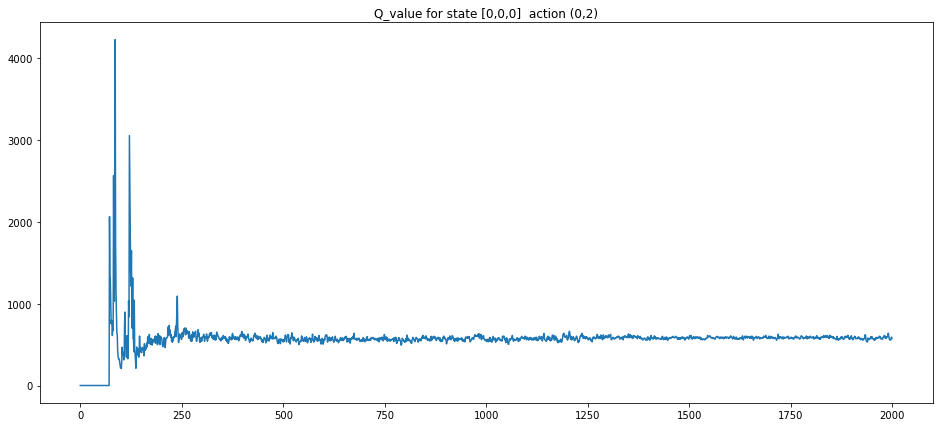

In [10]:
plt.figure(0, figsize=(16,7))
ax = plt.axes()
x = np.asarray(range(0, len(agent.states_tracked)))
y = np.asarray(agent.states_tracked)
plt.title('Q_value for state [0,0,0]  action (0,2)')
ax.plot(x, y);

## The Q Values are converging after initial fluctuations (expected)

## Check whether the total rewards earned per episode are showing stability

In [11]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 10 == 0)]

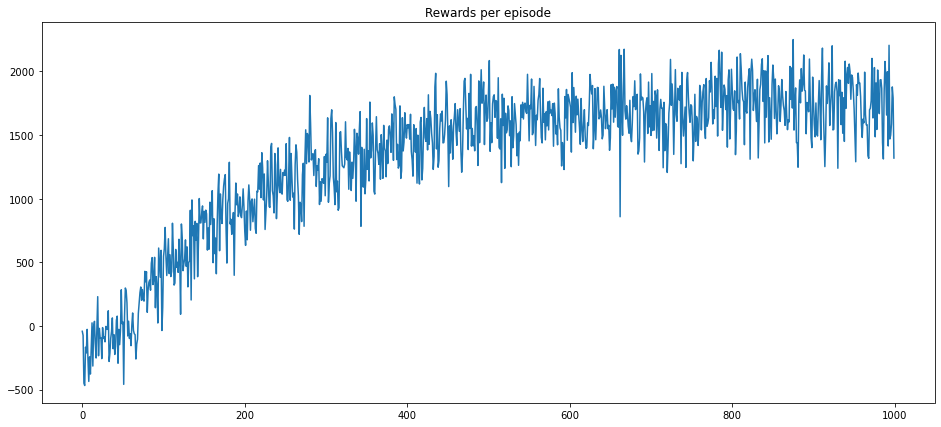

In [12]:
plt.figure(0, figsize=(16,7))
ax = plt.axes()
plt.title('Rewards per episode')
x = np.asarray(range(0, len(score_tracked_sample)))
y = np.asarray(score_tracked_sample)
ax.plot(x, y);

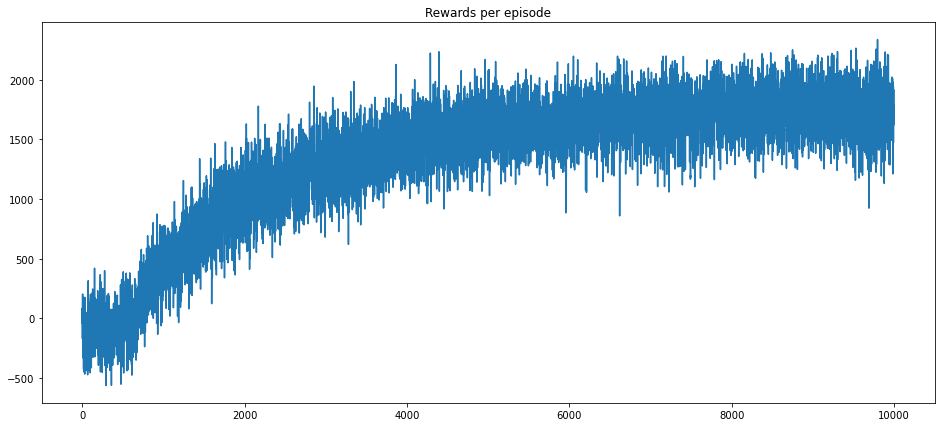

In [13]:
plt.figure(0, figsize=(16,7))
ax = plt.axes()
plt.title('Rewards per episode')
x = np.asarray(range(0, len(score_tracked)))
y = np.asarray(score_tracked)
ax.plot(x, y);

## The rewards are converging after 5000 iterations

### Epsilon-decay function used

In [14]:
import numpy as np
time = np.arange(0,10000)
epsilon = []

# Defined Parameters 
# self.epsilon_decay = -0.0005
# self.epsilon_min = 0.00001    

for i in range(0,10000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

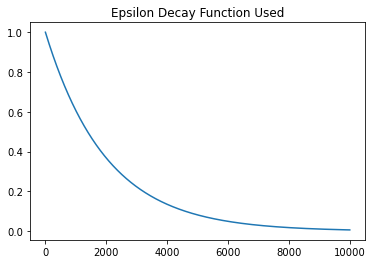

In [15]:
import matplotlib.pyplot as plt
plt.title('Epsilon Decay Function Used')
plt.plot(time, epsilon)
plt.show()